In [12]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from tensorflow.keras.layers import LeakyReLU

import numpy as np
import pandas as pd


In [2]:
import numpy as np
import pandas as pd

sectors_data = {}
excel_file_path = 'logreturns_2000_2020_data_by_sector.xlsx'
snp_price_data = pd.ExcelFile(excel_file_path)
for sheet_name in snp_price_data.sheet_names:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    sheet_data['Date'] = pd.to_datetime(sheet_data['Unnamed: 0'], format='%Y-%m-%d')
    sheet_data.set_index('Date', inplace=True)
    sheet_data.drop(columns='Unnamed: 0', inplace=True)
    sectors_data[sheet_name] = sheet_data

# 데이터프레임 생성
df = pd.DataFrame()
for sector, data in sectors_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

df = df[1:]

In [3]:
#스케일링을 위한 학습데이터와 테스트데이터 셋 분리
train_scaling_size = int(len(df) * 0.7)
t_train_X = df[0 : train_scaling_size]
t_train_y = df[0 : train_scaling_size]


# 전체 데이터 중 최소값과 최대값 구하기
tot_train_min = np.minimum.reduce([t_train_X.min(axis=0), t_train_X.min(axis=0)])
tot_train_max = np.maximum.reduce([t_train_X.max(axis=0), t_train_X.max(axis=0)])

# 각 주식의 범위를 계산
train_range = tot_train_max - tot_train_min

In [4]:
import pandas as pd

end_date = pd.Timestamp('2020-12-31')
one_month = pd.DateOffset(months=1)
sixty_days = pd.DateOffset(days=60)

data_X = []
data_y = []
start_day_idx = [] # data_X를 생성하기 위한 매달 시작일 인덱스 리스트

# data_y부터 생성
start_date = pd.Timestamp('2000-04-01')

while start_date < end_date:
    end_of_period = start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    selected_data = df[(df.index >= start_date) & (df.index <= end_of_period)]

    indexing = df.index.get_loc(selected_data.index[0])

    # 각 주식에 대한 월별 평균 수익률 계산
    average_values = selected_data.mean(axis=0)

    data_y.append(average_values)
    start_day_idx.append(indexing)
    start_date = start_date + pd.DateOffset(months=1)  # Move to next month

start_date = pd.Timestamp('2000-01-01')

i = 0
while i < len(data_y):
    index_day_start = start_day_idx[i]

    nearest_index = None
    for j in range(index_day_start - 1, index_day_start - 61, -1):
        if j < 0:
            break
        if df.index[j] in df.index:
            nearest_index = j
            break

    if nearest_index is not None:
        sixty_day_data = df.iloc[nearest_index - 60 : nearest_index]
        data_X.append(sixty_day_data)
    else:
        pass

    i += 1

In [5]:
#학습데이터와 테스트데이터 셋 분리
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# # test_size = len(data_y) - train_size
# test_X = np.array(data_X[train_size : len(data_X)])
# test_y = np.array(data_y[train_size : len(data_y)])

#테스트데이터는 전체 데이터로~
test_X = np.array(data_X)
test_y = np.array(data_y)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (174, 60, 55) (174, 55)
테스트 데이터의 크기 : (249, 60, 55) (249, 55)


In [6]:
# 스케일링
train_X = (train_X - tot_train_min) / (train_range + 1e-7)
train_y = (train_y - tot_train_min) / (train_range + 1e-7)
test_X = (test_X - tot_train_min) / (train_range + 1e-7)
test_y = (test_y - tot_train_min) / (train_range + 1e-7)

In [7]:
test_X = np.reshape(test_X, (-1, 60, 55))

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.initializers import RandomNormal

# 가중치 초기화 방법 설정
init = RandomNormal(mean=0., stddev=0.05)

model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(60, 55)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu', kernel_initializer=init))
model.add(Dropout(0.1))
model.add(Dense(units=55, kernel_initializer=init))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            6080      
                                                                 
 dropout (Dropout)           (None, 60, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 55)                1155      
                                                                 
Total params: 10515 (41.07 KB)
Trainable params: 10515 (41.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [9]:
def GRU_model_regularization(X_train, y_train, X_test):
    """
    create a GRU model trained on X_train and y_train
    and make predictions on the X_test data
    """
    # create a model
    # The GRU architecture
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, return_sequences = True, input_shape = (60, 55)))
    my_GRU_model.add(LeakyReLU())
    my_GRU_model.add(GRU(units = 50))
    my_GRU_model.add(LeakyReLU())
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units = 55))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting to the trainig set
    my_GRU_model.fit(X_train, y_train, epochs = 500, batch_size = 256, verbose = 1)

    # Predicting on test sets
    GRU_prediction = my_GRU_model.predict(X_test)

    return my_GRU_model, GRU_prediction


In [10]:
# 옵티마이저와 손실함수 결정 및 학습 실행
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=500, batch_size=256)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 0.3073
Epoch 2/500
1/1 [==============================] - 0s 117ms/step - loss: 0.3055
Epoch 3/500
1/1 [==============================] - 0s 117ms/step - loss: 0.3038
Epoch 4/500
1/1 [==============================] - 0s 105ms/step - loss: 0.3020
Epoch 5/500
1/1 [==============================] - 0s 102ms/step - loss: 0.3002
Epoch 6/500
1/1 [==============================] - 0s 107ms/step - loss: 0.2980
Epoch 7/500
1/1 [==============================] - 0s 108ms/step - loss: 0.2956
Epoch 8/500
1/1 [==============================] - 0s 108ms/step - loss: 0.2930
Epoch 9/500
1/1 [==============================] - 0s 104ms/step - loss: 0.2898
Epoch 10/500
1/1 [==============================] - 0s 101ms/step - loss: 0.2860
Epoch 11/500
1/1 [==============================] - 0s 103ms/step - loss: 0.2817
Epoch 12/500
1/1 [==============================] - 0s 115ms/step - loss: 0.2761
Epoch 13/500
1/1 [======================

In [13]:
my_GRU_model, GRU_prediction = GRU_model_regularization(train_X, train_y, test_X)
# 예측 결과 얻기
LSTM_prediction = model.predict(test_X)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 0.3218
Epoch 2/500
1/1 [==============================] - 0s 128ms/step - loss: 0.3022
Epoch 3/500
1/1 [==============================] - 0s 144ms/step - loss: 0.2856
Epoch 4/500
1/1 [==============================] - 0s 143ms/step - loss: 0.2695
Epoch 5/500
1/1 [==============================] - 0s 144ms/step - loss: 0.2565
Epoch 6/500
1/1 [==============================] - 0s 132ms/step - loss: 0.2421
Epoch 7/500
1/1 [==============================] - 0s 145ms/step - loss: 0.2290
Epoch 8/500
1/1 [==============================] - 0s 146ms/step - loss: 0.2166
Epoch 9/500
1/1 [==============================] - 0s 145ms/step - loss: 0.2022
Epoch 10/500
1/1 [==============================] - 0s 150ms/step - loss: 0.1893
Epoch 11/500
1/1 [==============================] - 0s 149ms/step - loss: 0.1770
Epoch 12/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1629
Epoch 13/500
1/1 [======================

In [14]:
test_y = test_y * (train_range + 1e-7) + tot_train_min
LSTM_prediction = LSTM_prediction * (train_range + 1e-7) + tot_train_min
GRU_prediction = GRU_prediction * (train_range + 1e-7) + tot_train_min

In [15]:
import matplotlib.pyplot as plt

stocks = {
        'Tele' : ['VZ', 'DIS', 'T', 'CMCSA', 'EA'],
        'COND' : ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX'],
        'ENRG': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
        'HLCA' : ['JNJ', 'PFE', 'UNH','MRK','ABT'],
        'INDS' : ['BA', 'MMM','UNP','HON','RTX'],
        'MTRS': ['PPG', 'APD', 'ECL', 'SHW', 'NEM'],
        'FINC' : ['JPM', 'BRK-B', 'BAC', 'WFC', 'C'],
        'CONS' : ['PG', 'KO', 'PEP','WMT','MO'],
        'INFT' : ['AAPL','MSFT','INTC','CSCO','ORCL'],
        'UTIL' : ['NEE','DUK','D','SO','EXC'],
        'REES' : ['AMT', 'SPG', 'CCI', 'PLD', 'PSA']
    }



# 각 주식에 대한 그래프 그리기 위해 회사 리스트 생성
company_list = []
for sector in stocks:
    company_list += stocks[sector]

plt.rcParams['font.size'] = 20

# 각 주식 별 예측값&실제값 그래프 그리기
for i, company in enumerate(company_list):
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    plt.plot(test_y[:,i], color='green', label='Actual Stock Price of ' + company)

    # 예측 데이터 그래프
    plt.plot(LSTM_prediction[:,i], color='red', label='LSTM ' + company)

    plt.plot(GRU_prediction[:,i], color='blue', label='GRU ' + company)

    plt.title('Stock Price Prediction of ' + company)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [17]:
# 각 섹터별 예측값&실제값 그래프 그리기

plt.rcParams['font.size'] = 20

for sector in stocks:
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    avg_test_y = np.mean([test_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_test_y, color='green', label='Average Real Stock Price of ' + sector)

    # 예측 데이터 그래프
    avg_pred_LSTM = np.mean([LSTM_prediction[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_LSTM, color='red', label='LSTM ' + sector)
    # 예측 데이터 그래프
    avg_pred_GRU = np.mean([GRU_prediction[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_GRU, color='blue', label='GRU ' + sector)

    plt.title('Average Stock Price Prediction of ' + sector, fontsize=36)
    plt.xlabel('Time', fontsize=36)
    plt.ylabel('Stock Price', fontsize=36)
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

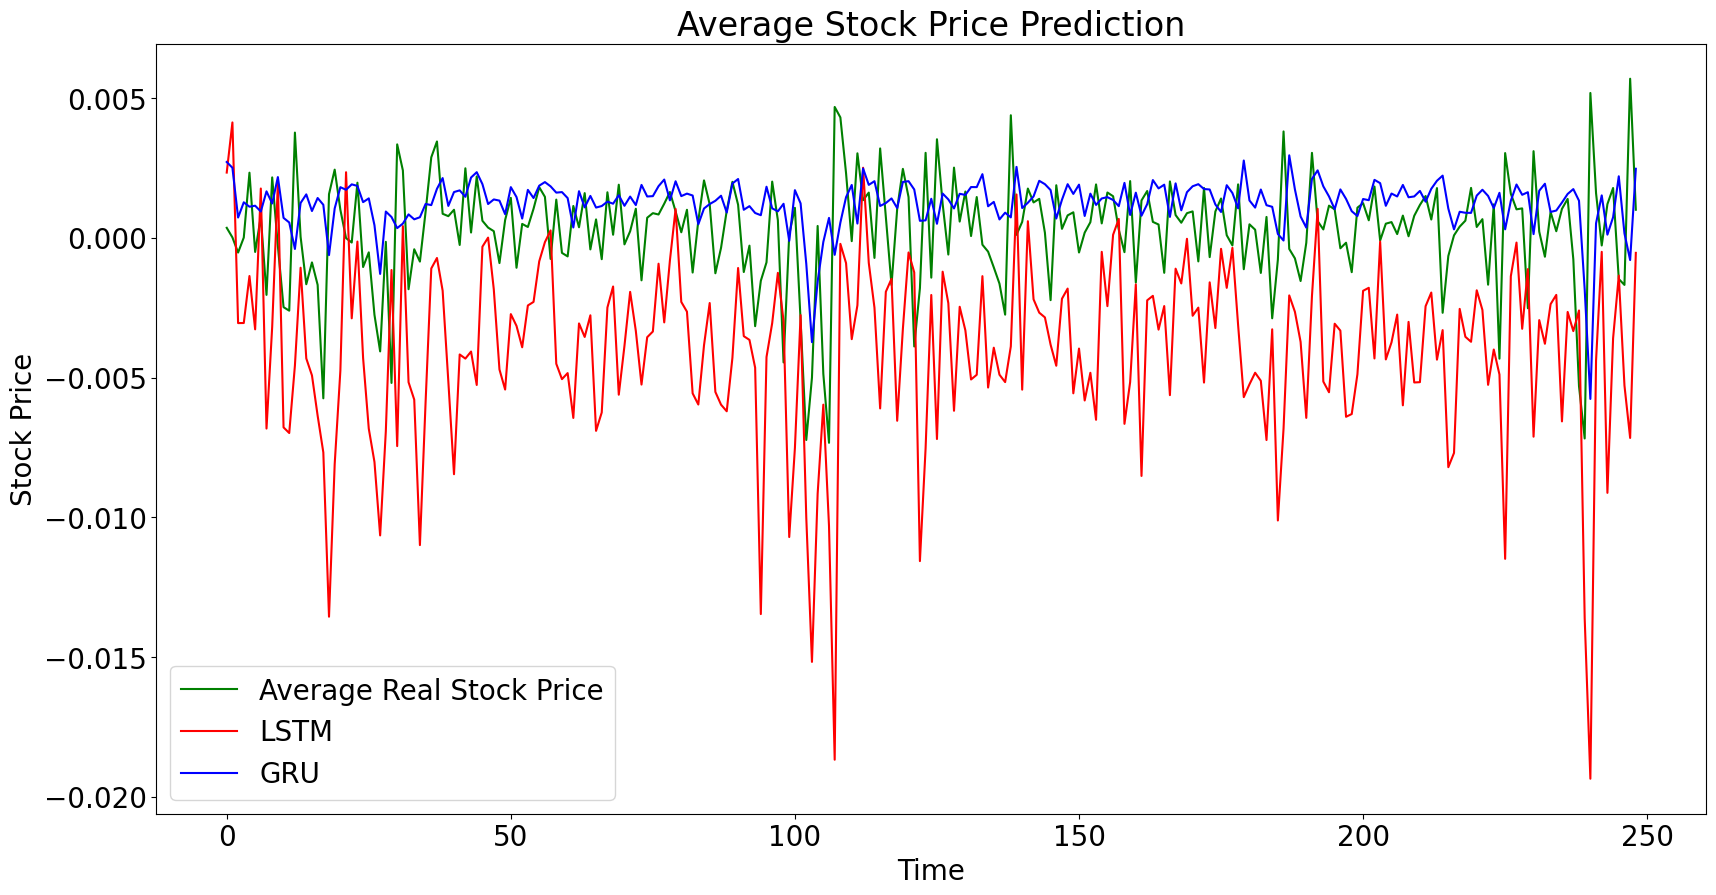

In [18]:
# 모든 주식의 평균 예측값& 실제값 그래프 그리기

plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,10))

# 실제 데이터 그래프
avg_test_y = np.mean(test_y, axis=1)
plt.plot(avg_test_y, color='green', label='Average Real Stock Price')

# 예측 데이터 그래프
avg_pred_LSTM = np.mean(LSTM_prediction, axis=1)
plt.plot(avg_pred_LSTM, color='red', label='LSTM')

avg_pred_GRU = np.mean(GRU_prediction, axis=1)
plt.plot(avg_pred_GRU, color='blue', label='GRU')


plt.title('Average Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()